# Estatística da violência no twitter

[Voltar ao Índice](00_indice.ipynb)

Aqui analisamos a quantidade de violência detectada nas respostas a tweets de candidatos pelo modelo de IA,
e como essas respostas de distribuem pelos candidatos, por dimensões dos candidatos (e.g. gênero e raça) e 
temporalmente. Nosso objetivo é entender se existem alvos privilegiados e gatilhos para a violência.

**ATTENTION:** This notebook uses data that is not available in this project due to legal restrictions by the Brazilian Personal Data Protection Law ([LGPD](https://www.planalto.gov.br/ccivil_03/_ato2015-2018/2018/lei/l13709.htm)).

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib as mpl
from importlib import reload
import matplotlib.pyplot as pl

import src.xavy.explore as xe
import src.xavy.dataframes as xd

import src.tweet_analysis as com

## Funções

In [2]:
def landmark(datetime, text, y=12000, color='r'):
    """
    Place a vertical line with a label on a time series
    plot.
    """
    pl.axvline(pd.to_datetime(datetime), color=color, linewidth=1)
    pl.text(pd.to_datetime(datetime), y, ' ' + text, fontsize=12, color=color)

## Carregando os dados

In [3]:
# Carrega as configurações:
config = com.read_config()

In [4]:
# Registro de pools de IDs utilizados:
source_df = com.load_id_pool_sources(config['id_pool_sources'])

# Carrega todos os arquivos de pool de perfis de candidatos:
id_dfs = com.load_ID_pools(config['id_pool_dir'], source_df)

# Load capture logs:
batch_df = com.load_batch_logs(config['batch_logs_dir'], source_df)

# Load tweets:
tweets_df = com.etl_tweets_df(config['scored_tweets_dir'], config['target_model'], config['bad_users'])

# Filter tweets directed to a single person:
direct_df = com.select_direct_text_tweets(tweets_df)

# Lista de candidatos:
target_df = id_dfs[source_df['file'].iloc[-1]]

# Pesos para os diferentes pools de IDs ao calcular o agregado sobre os candidatos:
list_factors = pd.read_csv(config['pool_factor_file']).set_index('pool_filename')

In [7]:
# Análise individual de exemplos:
#direct_df.set_index('tweet_url')[['text', 'hate_score', 'target_prob', 'final_prob']].query('hate_score - final_prob > 0.5').style.set_properties(subset=['text'], **{'width': '1500px'})

## Perfis que deram erro

In [19]:
# Batches que deram problema:
error_ids = batch_df.query('status == "error"')
error_counts = error_ids['id'].value_counts()
error_counts.name = 'n_errors'
error_ids = error_ids.drop_duplicates(subset=['cand_id_pos', 'id', 'file'], keep='last')
# Coleta os usuários das tabelas apropriadas:
perfis_df = pd.concat([pd.read_csv(f).query('id == {}'.format(u)) for u, f in zip(error_ids['id'], '../dados/processados/' + error_ids['file'])])
perfis_df = perfis_df.join(error_counts, on='id')

perfis_df

,username,created_at,id,name,description,verified,protected,withheld,lower_name,SQ_CANDIDATO,...,DS_GRAU_INSTRUCAO,DS_COR_RACA,DS_URL,followers_count,following_count,tweet_count,listed_count,sample_weight,source,n_errors
1602,CarlaZambelli38,2022-08-16T16:13:31.000Z,1559574001927733253,Lula Lá,É 13!!,False,False,NaN,carlazambelli38,250001611365,...,SUPERIOR COMPLETO,BRANCA,https://www.twitter.com/CarlaZambelli38,24.0,1.0,3.0,0.0,1.0,NaN,3
1819,lauraserranomg,2016-06-24T13:23:56.000Z,746333033389764608,Laura Serrano,⁣ 🇧🇷Deputada Estadual mais bem votada pelo @pa...,True,False,NaN,lauraserranomg,130001598591,...,SUPERIOR COMPLETO,BRANCA,https://www.twitter.com/lauraserranomg,3777.0,82.0,821.0,52.0,1.0,twitter,1
405,emersonosasco,2016-02-09T19:58:05.000Z,4892851287,Emerson Osasco,✊🏿 CANDIDATO A DEPUTADO ESTADUAL (REDE-SP) 🚀 V...,True,False,NaN,emersonosasco,250001619345,...,SUPERIOR COMPLETO,PRETA,https://twitter.com/emersonosasco?t=NaF1YO87cB...,35127.0,332.0,998.0,27.0,1.0,twitter,1
55,Patricia,2011-01-26T20:17:07.000Z,243326392,Gassho Terapias Holísticas Patricia Esquivel,NaN,False,True,NaN,patricia,190001638629,...,ENSINO MÉDIO COMPLETO,PARDA,https://twitter.com/patricia.ladeira51,2240.0,24.0,141.0,171.0,0.5,twitter,5
2756,elissamagomes,2014-08-14T14:16:56.000Z,2731816712,elissama tereza,"branca,cantora , estudante,casada",False,False,NaN,elissamagomes,270001643552,...,SUPERIOR COMPLETO,PARDA,https://www.instagram.com/elissamagomes/,145.0,148.0,48.0,0.0,1.0,instagram,12
2243,Janneruth,2011-01-06T20:41:49.000Z,234888981,Janne Ruth BBB 22 #teemarthur🍞,"Assistente social,, foi bailarina.\nProdutora ...",False,False,NaN,janneruth,60001603544,...,SUPERIOR COMPLETO,BRANCA,https://twitter.com/janneruth?s=11&t=b_pPbIqbQ...,1096.0,2774.0,8710.0,0.0,1.0,twitter,8


In [10]:
# Batches que deram problema:
error_ids = batch_df.query('status == "queue"').drop_duplicates(subset=['cand_id_pos', 'id', 'file'], keep='last')
# Coleta os usuários das tabelas apropriadas:
perfis_df = pd.concat([pd.read_csv(f).query('id == {}'.format(u)) for u, f in zip(error_ids['id'], '../dados/processados/' + error_ids['file'])])

perfis_df

,name,description,protected,username,verified,id,created_at,withheld,lower_name,SQ_CANDIDATO,...,DS_GENERO,DS_GRAU_INSTRUCAO,DS_COR_RACA,DS_URL,followers_count,following_count,tweet_count,listed_count,sample_weight,source
2623,Reinaldo Alguz,Deputado Estadual. Autor da lei que prevê o us...,False,reinaldoalguz,False,252553700,2011-02-15T12:39:53.000Z,NaN,reinaldoalguz,250001602077,...,MASCULINO,SUPERIOR COMPLETO,BRANCA,https://www.instagram.com/reinaldoalguz/,761.0,21.0,2865.0,43.0,1.0,instagram
1887,Wanderlei Silva,Manager @jeanfaillace,False,wandfc,False,60694754,2009-07-27T20:03:49.000Z,NaN,wandfc,160001603308,...,MASCULINO,ENSINO MÉDIO COMPLETO,BRANCA,https://twitter.com/wandfc,735430.0,48680.0,25474.0,3153.0,1.0,twitter
1068,Symmy Larrat,🏳️‍⚧️ 1ª travesti candidata a Deputada Federal...,False,larratsymmy,False,1425122913125126154,2021-08-10T15:52:48.000Z,NaN,larratsymmy,250001610644,...,FEMININO,SUPERIOR COMPLETO,BRANCA,https://mobile.twitter.com/larratsymmy,263.0,191.0,175.0,5.0,1.0,twitter
2910,Ivar Pavan,"Pai do Diego e da Caroline, casado com a Salet...",False,Ivarpavan,False,71307963,2009-09-03T17:25:06.000Z,NaN,ivarpavan,210001610618,...,MASCULINO,ENSINO FUNDAMENTAL INCOMPLETO,BRANCA,https://instagram.com/ivarpavan,1993.0,566.0,746.0,45.0,1.0,instagram
627,André Nogueira,Advogado | Apresentador de Rádio,False,nogueiractb,False,1196998359900397568,2019-11-20T03:47:16.000Z,NaN,nogueiractb,160001614530,...,MASCULINO,SUPERIOR COMPLETO,PARDA,https://www.twitter.com/nogueiractb,105.0,236.0,1419.0,0.0,1.0,twitter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687,Dra. Damaris Moura,Deputada estadual eleita por São Paulo com 45....,True,DamarismouraDra,False,1143221994885959680,2019-06-24T18:18:58.000Z,NaN,damarismouradra,250001611428,...,FEMININO,SUPERIOR COMPLETO,BRANCA,https://twitter.com/DamarismouraDra,686.0,28.0,390.0,17.0,1.0,twitter
1196,Robertaz.,"sou a mamãe, mulher, menina, senhora, professo...",False,robertazannon,False,1115047537923301376,2019-04-08T00:23:44.000Z,NaN,robertazannon,130001615257,...,FEMININO,SUPERIOR COMPLETO,BRANCA,https://twitter.com/robertazannon,288.0,601.0,298.0,1.0,1.0,twitter
1624,Caminhão da Vereança 65065 🫰🏼,Vereadora pelo PCdoB em Ijuí / Graduada em Dir...,False,Gubianib,False,2665161042,2014-07-21T07:13:53.000Z,NaN,gubianib,210001610600,...,FEMININO,SUPERIOR COMPLETO,BRANCA,https://twitter.com/gubianib,398.0,698.0,7956.0,0.0,1.0,twitter
393,Carol Sponza,Advogada.\nMestre em Politicas Públicas pela H...,False,carolsponza30,False,966007662541443074,2018-02-20T17:52:29.000Z,NaN,carolsponza30,190001598406,...,FEMININO,SUPERIOR COMPLETO,BRANCA,https://www.twitter.com/carolsponza30,379.0,343.0,194.0,1.0,1.0,twitter


## Exploração geral

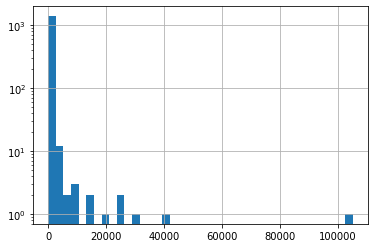

In [50]:
tweets_df.groupby('batch_user')['t_win_weight'].sum().sort_values().hist(bins=40)
pl.yscale('log')
pl.show()

In [32]:
tweets_df.sample(4).transpose()

,34335,57221,147015,30404
author_id,805566339167428612,1109601156316254208,777305960578768896,1278478499574054917
id,1560002490828988416,1560331480592777218,1561367316369182720,1559943284457349120
created_at,2022-08-17 20:35:51+00:00,2022-08-18 18:23:09+00:00,2022-08-21 14:59:11+00:00,2022-08-17 16:40:36+00:00
entities,"{'mentions': [{'start': 0, 'end': 15, 'usernam...","{'mentions': [{'start': 0, 'end': 15, 'usernam...","{'mentions': [{'start': 0, 'end': 16, 'usernam...","{'mentions': [{'start': 0, 'end': 8, 'username..."
text,@marcofeliciano @jairbolsonaro Sucesso!,@marcofeliciano Vamos chamar ele de Lula ladrão.,@GuilhermeBoulos @dilmabr https://t.co/6b3hGQZZXe,@TheKiuz @oronaldoreis @Davi_blandy @sccorinth...
in_reply_to_user_id,35805725.0,35805725.0,762402774260875264.0,217374893.0
author_name,Luis Fontes,Antonio Aurélio de Alencar,Vera Bolsonaro 2022💙💛💚🇧🇷,Cruzeiro 🦊 🅨
author_username,LFontes_VIX,AntonioAurliod1,verajaxb4000,Cruzeifo
tweet_url,https://www.twitter.com/LFontes_VIX/status/156...,https://www.twitter.com/AntonioAurliod1/status...,https://www.twitter.com/verajaxb4000/status/15...,https://www.twitter.com/Cruzeifo/status/155994...
n_mentions,2,1,2,6


## Produção de métricas

In [5]:
# Recorte aplicado aos dados:
query  = config['cand_sel_query']
#query  = 'DS_GENERO != "NENHUM"'
capture_period = config['capture_period']

# IDs disponíveis em cada lista (removidos usuários errados):
id_ids = {k:set(id_dfs[k].query(query)['id']) - set(config['bad_users']) for k in id_dfs.keys()}
# IDS e data da última lista como referência:
ref_ids   = id_ids[source_df['file'].iloc[-1]]
ref_start = source_df['first_batch'].iloc[-1]

In [6]:
# Seleciona tweets direcionados às candidaturas especificadas:
selection_df = com.sel_ids(direct_df, id_ids['twitter_ids_deputados_2022_v04.csv'])

# Compute deseasonalyzing factor (to impute missing scheduled batches):
season_index = com.hour_seasonal_factor(tweets_df)
season_index.name = 'season_index'

# Aggregate tweets over candidates to produce tweets counts and hate counts time series:
capture_df = com.aggregate_tweet_counts_over_candidates(selection_df, batch_df, ref_ids, list_factors, season_index, config['official_start'], config['capture_period'])

In [7]:
# Aggregate counts over time to create a series per day:
yesterday    = (pd.to_datetime('today') - pd.DateOffset(days=1)).date()
hate_series  = com.sum_per_day(capture_df.reset_index(), 'final_n_hate', 'index', capture_period).loc[:yesterday]
tweet_series = com.sum_per_day(capture_df.reset_index(), 'final_n_tweets', 'index', capture_period).loc[:yesterday]

In [8]:
reload(com)

<module 'src.tweet_analysis' from '/home/skems/ceweb/projetos/violentometro/analises/src/tweet_analysis.py'>

In [9]:
hate_series.mean()

1513.6468345205838

In [10]:
com.data_to_csv(hate_series, tweet_series, config['time_series_csv'])

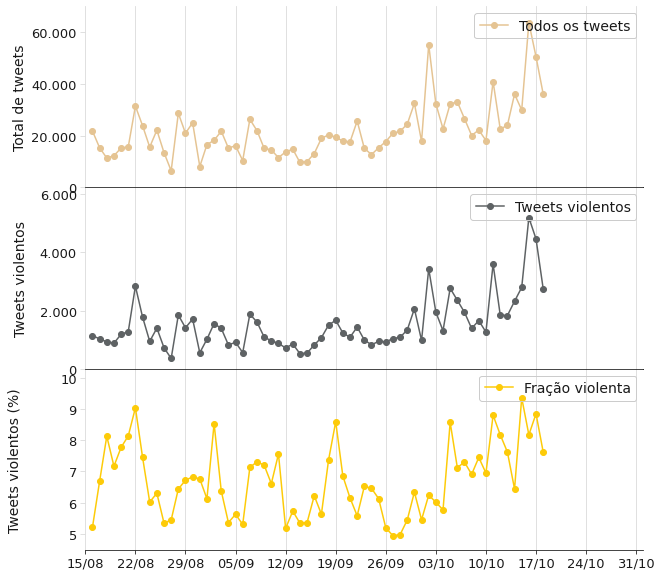

In [11]:
# Cria e salva gráfico:
fig_name = config['time_series_plot'].format(pd.to_datetime('today').strftime('%Y-%m-%d'))
fig = com.plot_hate_daily_series(hate_series, tweet_series)
#fig.savefig(fig_name, transparent=True)

In [43]:
def save_webpage_data(hate_series, fig_name, filename='../tweets/webpage_data.json'):
    """
    Write big numbers and a plot filename regarding the 
    violence on twitter to a JSON file.
    
    Parameters
    ----------
    hate_series : Series
        Time series with daily frequency containing the 
        number of attacks directed to candidates per day
        since the beginning of the campaign.
    fig_name : str
        Filename of the plot showing the time series.
    filename : str
        Path to the JSON file that will save the information
        above.
    """
    
    # Pega a data de ontem:
    yesterday = (pd.to_datetime('today') - pd.DateOffset(days=1)).date()
    
    # Cria JSON com números e nome da figura:
    webpage_data = {'total_counts': int(hate_series.sum() + 0.5),
                    'yesterday_counts': int(hate_series[yesterday] + 0.5),
                    'time_series_plot': fig_name,
                    'last_update': pd.to_datetime('today').strftime('%Y-%m-%dT%H:%M:%S')}
    
    # Salva JSON:
    com.write_config(webpage_data, filename)

## Análises e atualizações

### Atualização da lista de fatores para normalizar diferentes pools de IDs

In [12]:
# Calcula pesos para os diferentes pools de IDs ao calcular o agregado sobre os candidatos:
list_factors_update = com.build_different_pop_factors(selection_df, id_ids, ref_ids, ref_start)
list_factors_update.index.name = 'pool_filename'
list_factors_update
#list_factors.to_csv('../dados/processados/pesos_diferentes_ID_pools_v01.csv')

,n_tweets_list_factor,n_hate_list_factor
pool_filename,,
twitter_ids_deputados_2022.csv,1.117483,1.025748
twitter+insta_ids_deputados_2022.csv,0.998515,0.992262
twitter+insta+lagom_ids_deputados_2022.csv,1.000000,1.000000
twitter_ids_deputados_2022_v04.csv,1.000000,1.000000


### Relação entre número de seguidores e tweets mencionando

In [13]:
# Número médio de seguidores dos candidatos em cada batch:
good_batch_df = batch_df.loc[batch_df['id'].isin(ref_ids) & (batch_df['status'] == 'ok')]
cross_df = pd.DataFrame()
cross_df['followers'] = good_batch_df.join(target_df.set_index('id')['followers_count'], on='id').groupby('batch_time')['followers_count'].mean()
cross_df['n_tweets'] = capture_df['final_n_tweets']

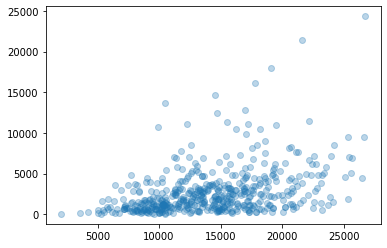

In [14]:
# Correlação entre quantidade média de seguidores e número de tweets em cada batch:

pl.scatter(cross_df['followers'], cross_df['n_tweets'], marker='o', alpha=0.3)
pl.show()

### Time series de núm. tweets

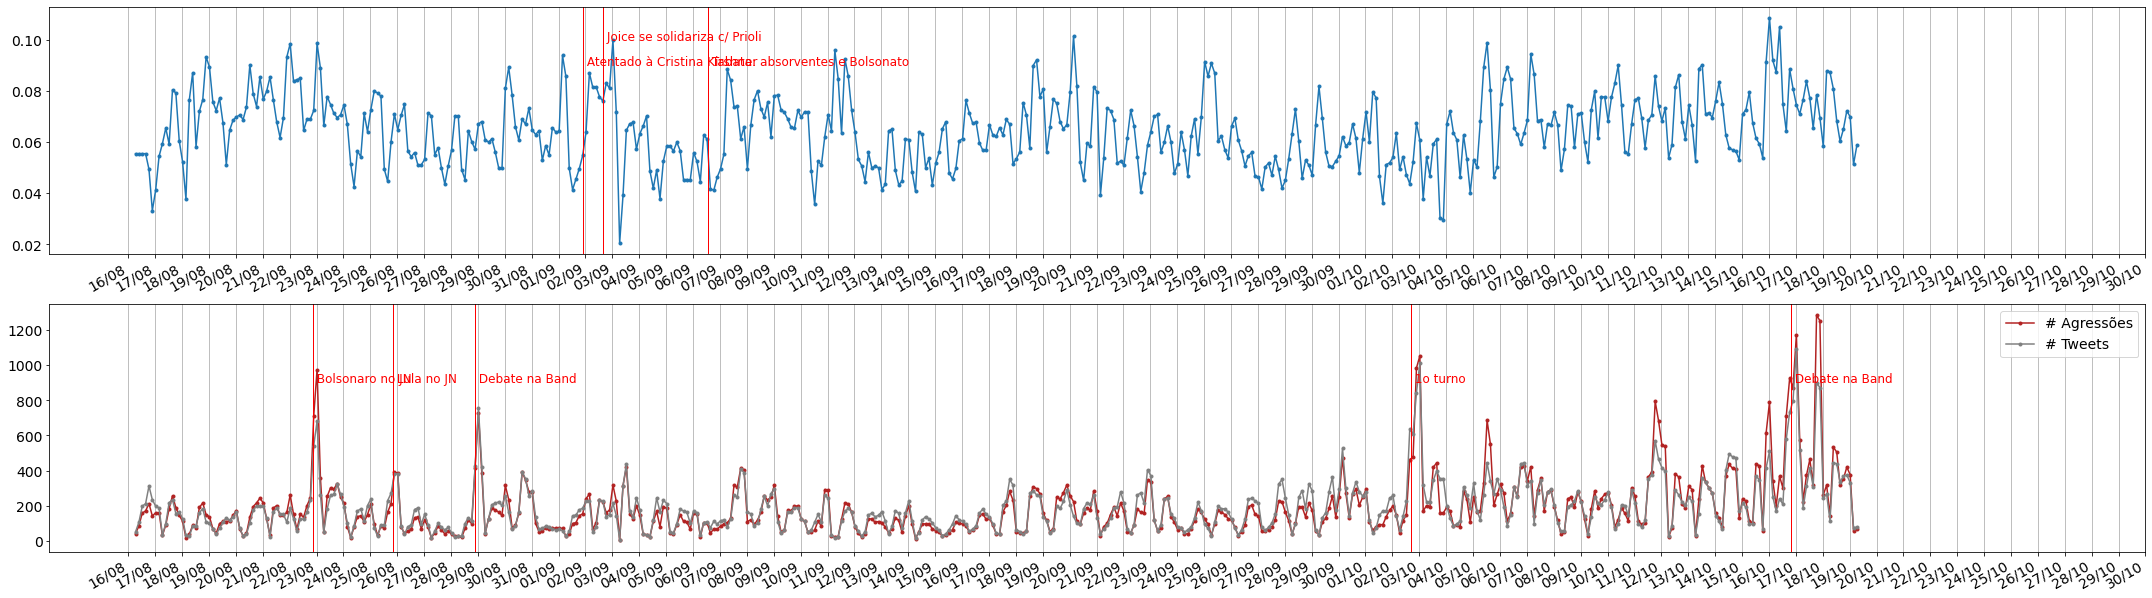

In [18]:
days = pd.date_range('2022-08-16', '2022-10-30')

pl.figure(figsize=(30,12))

pl.subplot(3,1,1)
(capture_df['final_n_hate'] / capture_df['final_n_tweets']).fillna(0).rolling(2).mean().plot(marker='.', label='Fração')
pl.xticks(days, days.strftime('%d/%m'))
pl.grid(axis='x')
pl.tick_params(labelsize=14)

landmark('2022-09-01 22:00:00', 'Atentado à Cristina Kirshner', 0.09)
landmark('2022-09-02 15:30:00', 'Joice se solidariza c/ Prioli', 0.10)
landmark('2022-09-06 13:00:00', 'Tabata: absorventes e Bolsonato', 0.09)

pl.subplot(3,1,2)
capture_df['final_n_hate'].fillna(0).rolling(2).mean().plot(marker='.', label='# Agressões', color='firebrick')
pl.xticks(days, days.strftime('%d/%m'))
pl.grid(axis='x')
pl.tick_params(labelsize=14)

fac = capture_df['final_n_hate'].sum() / capture_df['final_n_tweets'].sum()

(capture_df['final_n_tweets'] * fac).fillna(0).rolling(2).mean().plot(marker='.', label='# Tweets', color='gray')
pl.xticks(days, days.strftime('%d/%m'))
pl.grid(axis='x')
pl.tick_params(labelsize=14)


landmark('2022-08-22 20:30:00', 'Bolsonaro no JN', 900)
landmark('2022-08-25 20:30:00', 'Lula no JN', 900)
landmark('2022-08-28 21:00:00', 'Debate na Band', 900)
landmark('2022-10-02 17:00:00', '1o turno', 900)
landmark('2022-10-16 20:00:00', 'Debate na Band', 900)


pl.legend(fontsize=14)
pl.tight_layout()
#pl.savefig('plots/n_agressoes_por_batch_2022-08-30.png')
pl.show()

### Candidatos mais mencionados num dado batch

In [49]:
check_time = '2022-10-05 12:30:00'
print('Fração: {:.4f}'.format((capture_df['final_n_hate'] / capture_df['final_n_tweets'])[check_time]))
tweet_counts = selection_df.loc[selection_df['batch_time'] == check_time].groupby('batch_user')['t_win_weight'].sum()
hate_counts  = selection_df.loc[selection_df['batch_time'] == check_time].groupby('batch_user')['w_final_prob'].sum()
joined_df    = target_df.join(tweet_counts, on='id', how='inner').join(hate_counts, on='id', how='inner').sort_values('w_final_prob', ascending=False)[['id', 'name', 't_win_weight', 'w_final_prob']].head(10)
joined_df['frac_hate'] = joined_df['w_final_prob'] / joined_df['t_win_weight']
joined_df

Fração: 0.1242


,id,name,t_win_weight,w_final_prob,frac_hate
1051,116519514,Joice Hasselmann,2345.955882,317.407597,0.135300
1477,31139434,Gleisi Hoffmann 1313,214.000000,18.274503,0.085395
231,103704608,Talíria Petrone 5077,40.000000,1.419639,0.035491
852,57044549,Fernanda Melchionna 5️⃣0️⃣5️⃣0️⃣,47.000000,1.007482,0.021436
1604,1110626741314306049,Chris Tonietto,19.000000,0.962353,0.050650
794,20984842,Dani Maia,3.000000,0.222431,0.074144
2730,1353425986289868800,Robeyoncé 5000,7.000000,0.179051,0.025579
423,1164956374427721730,Duda é Lula 1️⃣3️⃣1️⃣8️⃣0️⃣,11.000000,0.169069,0.015370
3405,39116717,Jandira Feghali 6565 🇧🇷🚩,7.000000,0.107096,0.015299
336,1356434859934298115,Ana Pimentel,3.000000,0.105430,0.035143


In [50]:
check_id = 116519514 # Joice
#check_id = 1001251931812220928 # Tabata
#check_id = 357030742 # Bia Kicis
#check_id = 975127727501185025 # Zambelli
#check_id = 27703690 # Samia

batch_df.loc[(batch_df['batch_time'] == check_time) & (batch_df['id'] == check_id)]

,cand_id_pos,id,batch_size,batch_time,status,batch_start,batch_end,batch_tweets,batch_errors,filename,file,first_batch,last_batch
1805307,1051,116519514,1158,2022-10-05 12:30:00,ok,2022-10-05 09:36:25.152855,2022-10-05 12:36:25.152855,840.0,0.0,../tweets/logs/capture/capture_2022-10-05T12:3...,twitter_ids_deputados_2022_v04.csv,2022-08-22 18:30:00,2050-01-01


In [51]:
# Tweets aleatórios:
check_tweets_df = selection_df.loc[(selection_df['batch_time'] == check_time) & (selection_df['batch_user'] == check_id)]
print('# tweets:', len(check_tweets_df))
print('t_win_weight:', check_tweets_df['t_win_weight'].mean())
print('w_final_prob:', check_tweets_df['w_final_prob'].mean())
print('Tweets de {} a {}'.format(check_tweets_df['created_at'].min().strftime('%H:%M'), check_tweets_df['created_at'].max().strftime('%H:%M')))
xd.print_string_series(check_tweets_df.sample(5)['tweet_url'])

# tweets: 709
t_win_weight: 3.308823529411765
w_final_prob: 0.4476834933850855
Tweets de 11:41 a 12:36
1667182: https://www.twitter.com/Jesus0208111530/status/1577676515596242945
1667431: https://www.twitter.com/JairPer80178732/status/1577673053726703616
1667575: https://www.twitter.com/cantorlirico/status/1577670531310125057
1667124: https://www.twitter.com/Madmilk90/status/1577677499055620098
1667212: https://www.twitter.com/marotogaroto007/status/1577676107494703105


In [52]:
# Tweets mais violentos:
check_tweets_df = selection_df.loc[(selection_df['batch_time'] == check_time) & (selection_df['batch_user'] == check_id)]
print('# tweets:', len(check_tweets_df))
print('t_win_weight:', check_tweets_df['t_win_weight'].mean())
print('w_final_prob:', check_tweets_df['w_final_prob'].mean())
print('Tweets de {} a {}'.format(check_tweets_df['created_at'].min().strftime('%H:%M'), check_tweets_df['created_at'].max().strftime('%H:%M')))
xd.print_string_series(check_tweets_df.sort_values('w_final_prob', ascending=False).set_index('w_final_prob').head(10)['tweet_url'])

# tweets: 709
t_win_weight: 3.308823529411765
w_final_prob: 0.4476834933850855
Tweets de 11:41 a 12:36
3.2651842855609146: https://www.twitter.com/Fernand89800710/status/1577679363130130432
3.1003526495903166: https://www.twitter.com/jane_moron/status/1577682647001825284
3.098357134961404: https://www.twitter.com/JorgeSa05213164/status/1577678324284915713
3.055955326895433: https://www.twitter.com/Flvia344047092/status/1577676552149549061
3.0538156073734797: https://www.twitter.com/ArthurDeLuca4/status/1577682178535825408
3.0483640893071193: https://www.twitter.com/kinhoacn/status/1577673516471681031
3.0182496906565857: https://www.twitter.com/weldreneves/status/1577674118333431810
2.955710644104079: https://www.twitter.com/jaccoletti/status/1577678975500951552
2.9414802374063282: https://www.twitter.com/georgeamarcos/status/1577676163018899456
2.9280301892932967: https://www.twitter.com/LuiscelsoDeOli3/status/1577680893170311170


* Lidar com candidatos com o mesmo perfil.
* Verificar se variações no número de tweets são explicados pela seleção ou não de uma dada candidata.

### Avaliação da frequência de aparição de candidatos nos batches e dias

In [53]:
# Binary table if candidate is in batch or not:
cand_in_batch = good_batch_df.pivot_table(index='batch_time', columns='id', values='status', aggfunc='count').fillna(0).astype(int)

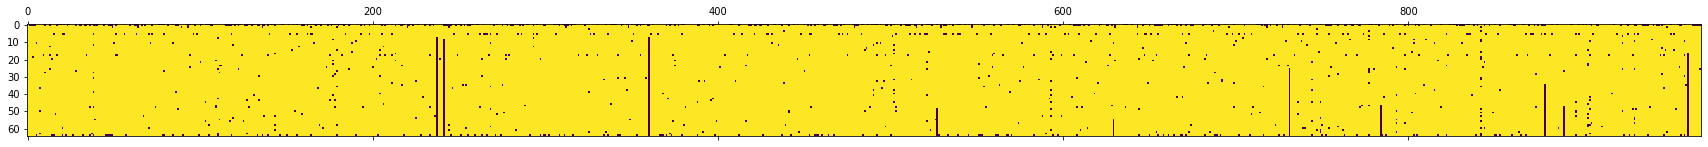

In [54]:
# Binary table is candidate is in day or not:
cand_in_day = cand_in_batch.groupby(cand_in_batch.index.date).sum().clip(upper=1)
pl.figure(figsize=(30,30))
pl.matshow(cand_in_day, fignum=1)
pl.show()

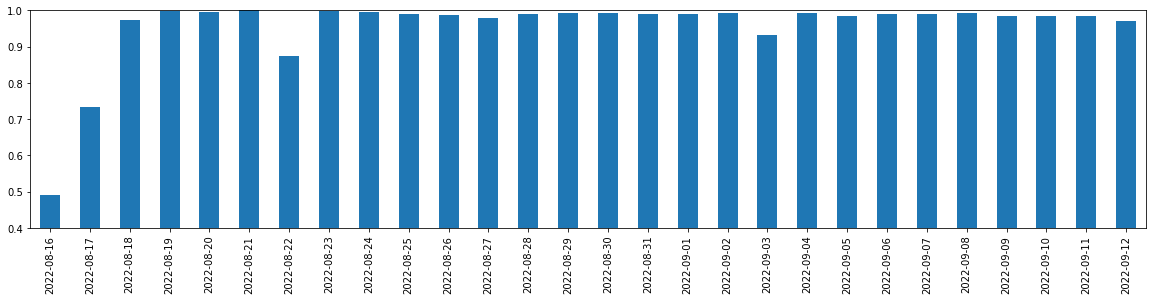

In [54]:
pl.figure(figsize=(20,4))
(cand_in_day.sum(axis=1) / cand_in_day.shape[1]).plot(kind='bar')
pl.ylim([0.4,1.0])
pl.show()

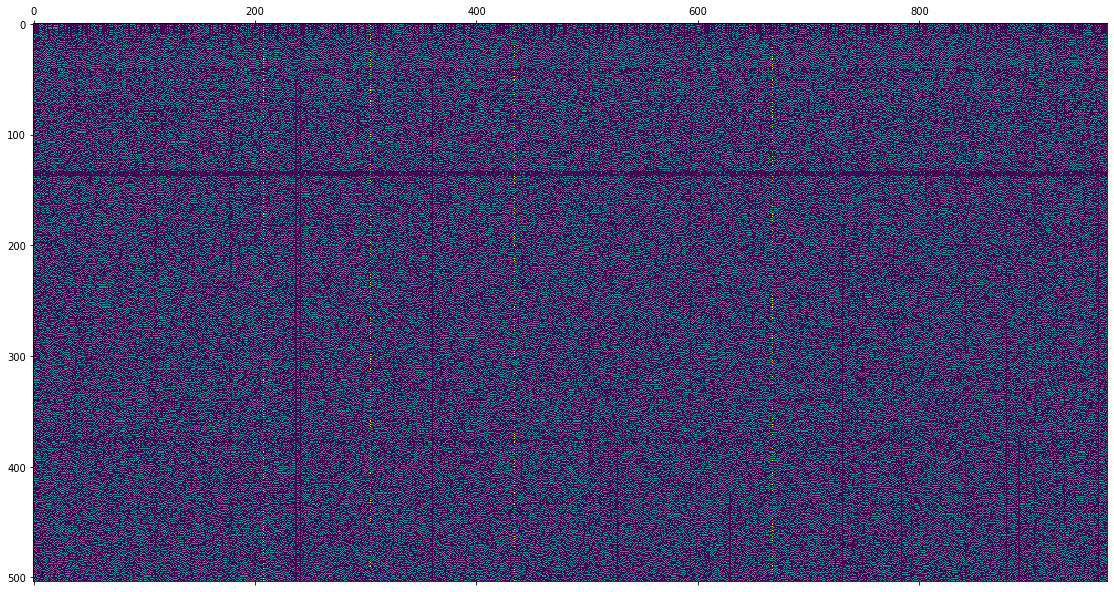

In [55]:
pl.figure(figsize=(30,10))
pl.matshow(cand_in_batch, fignum=1)
pl.show()

### Agressões a cada candidato

In [113]:
assert direct_df['batch_user'].dtype == int
assert target_df['id'].dtype == int

hate_df = pd.DataFrame()
hate_df['hate_counts']  = direct_df.groupby('batch_user')['w_final_prob'].sum()
hate_df['tweet_counts'] = direct_df.groupby('batch_user')['t_win_weight'].sum()
hate_df['response_counts'] = direct_df.groupby('batch_user')['w_hate_score'].sum() - direct_df.groupby('batch_user')['w_final_prob'].sum()

hate_df['hate_freq']    = hate_df['hate_counts'] / hate_df['tweet_counts']
hate_df['response_freq']= hate_df['response_counts'] / hate_df['tweet_counts']

target_hate_df = target_df.join(hate_df, on='id', how='right')

target_hate_df['label'] = target_df['DS_CARGO'].str.replace('DEPUTADO ', '') + ': ' + target_hate_df['NM_URNA_CANDIDATO'] + ' (' + target_hate_df['SG_PARTIDO'] + '-' + target_hate_df['SG_UF'] + ')'

In [32]:
direct_df.loc[~tweets_df['batch_user'].isin(set(target_df['id'])), ['text', 'batch_user']].drop_duplicates('batch_user')

,text,batch_user
1644,@home njDxzDxHAP,2817995382


### Violência direcionada a grupos

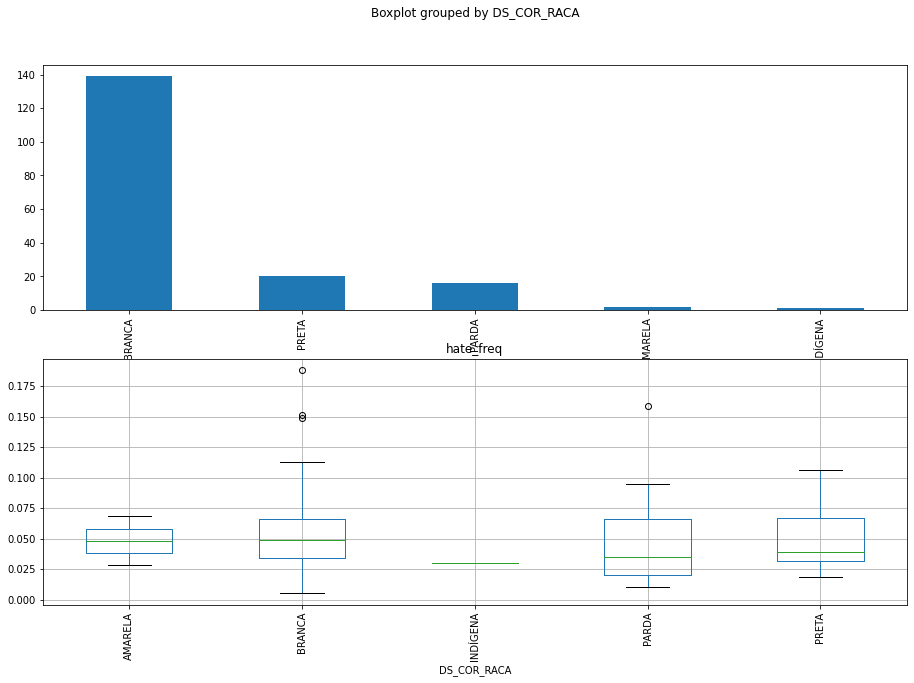

In [143]:
dimension = 'DS_COR_RACA'
pl.figure(figsize=(15,10))
pl.subplot(2,1,1)
sample_sizes = target_hate_df.query('tweet_counts > 50')[dimension].value_counts()
sample_sizes.plot(kind='bar')
pl.subplot(2,1,2)
ax = pl.gca()
target_hate_df.query('tweet_counts > 50').boxplot('hate_freq', by=dimension, ax=ax, rot=90)
pl.show()

### Parlamentares com mais tweets violentos

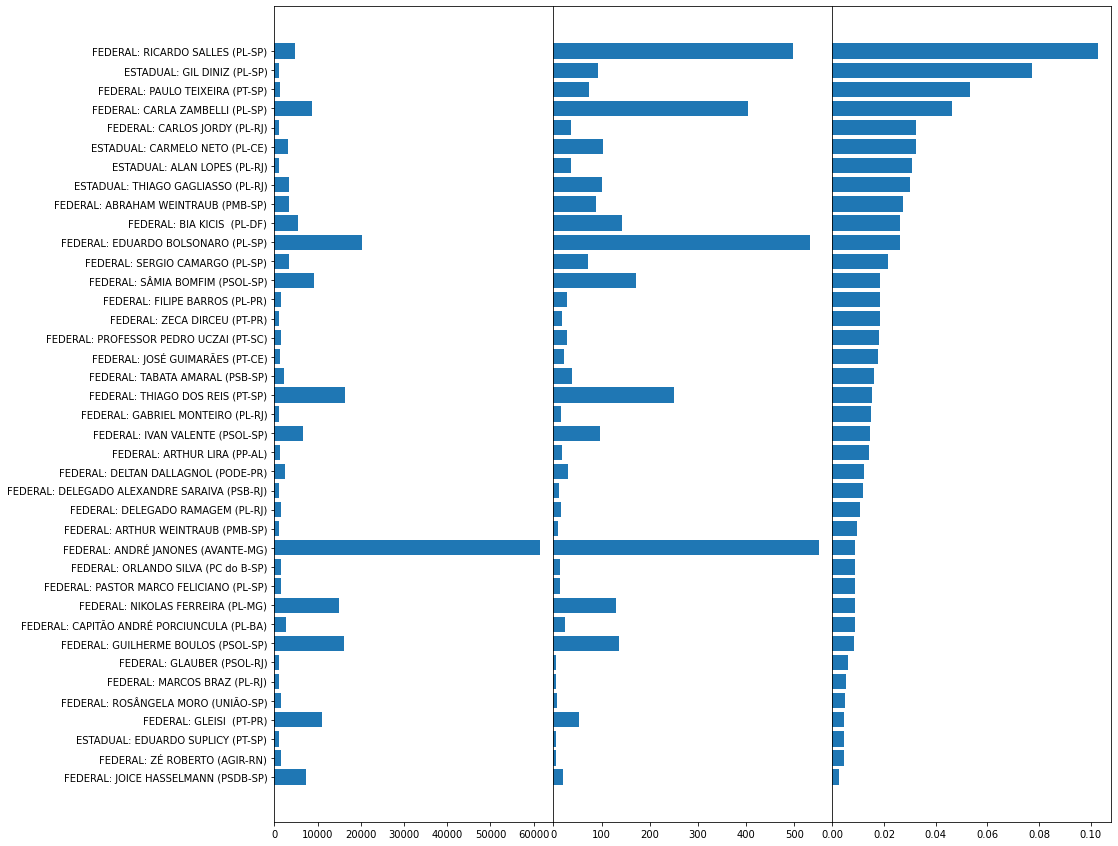

In [114]:
# Que promovem violência, provalmente:

sorted_target_hate_df = target_hate_df.query('tweet_counts >= 1000').sort_values('response_freq').tail(40)

pl.figure(figsize=(15,15))

pl.subplot(1,3,1)
pl.barh(sorted_target_hate_df['label'], sorted_target_hate_df['tweet_counts'])

pl.subplot(1,3,2)
pl.barh(sorted_target_hate_df['label'], sorted_target_hate_df['response_counts'])
pl.gca().get_yaxis().set_visible(False)
pl.subplots_adjust(wspace=0)

pl.subplot(1,3,3)
pl.barh(sorted_target_hate_df['label'], sorted_target_hate_df['response_freq'])
pl.gca().get_yaxis().set_visible(False)
pl.subplots_adjust(wspace=0)

pl.show()

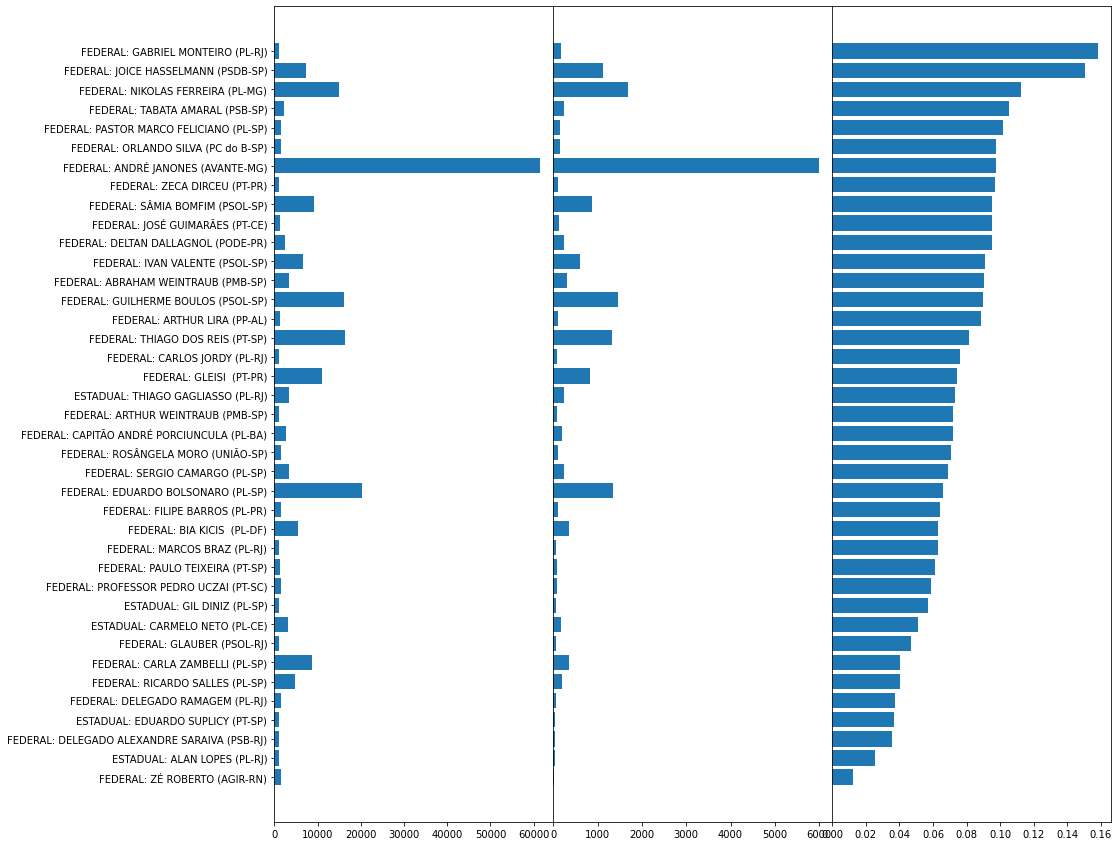

In [110]:
# Que sofrem violência:

sorted_target_hate_df = target_hate_df.query('tweet_counts >= 1000').sort_values('hate_freq').tail(40)

pl.figure(figsize=(15,15))

pl.subplot(1,3,1)
pl.barh(sorted_target_hate_df['label'], sorted_target_hate_df['tweet_counts'])

pl.subplot(1,3,2)
pl.barh(sorted_target_hate_df['label'], sorted_target_hate_df['hate_counts'])
pl.gca().get_yaxis().set_visible(False)
pl.subplots_adjust(wspace=0)

pl.subplot(1,3,3)
pl.barh(sorted_target_hate_df['label'], sorted_target_hate_df['hate_freq'])
pl.gca().get_yaxis().set_visible(False)
pl.subplots_adjust(wspace=0)

pl.show()